In [159]:
import pandas as pd 
import numpy as np
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import csv
from datetime import timedelta
from sqlalchemy import text

In [160]:
# Fixing trailing whitespaces
with open('SuperstoreSales_main.csv','r',encoding='ISO-8859-1') as inf , open('output.csv', 'w',encoding='ISO-8859-1') as of:
    r = csv.reader(inf, delimiter=';')
    w = csv.writer(of, delimiter=';')
    for line in r:
        trim = (field.strip() for field in line )
        w.writerow(trim)

# Read csv files into dataframes
sales = pd.read_csv('output.csv', encoding='ISO-8859-1',delimiter=';')
product = pd.read_csv('output.csv', encoding='ISO-8859-1',delimiter=';')
customer = pd.read_csv('output.csv', encoding='ISO-8859-1',delimiter=';')
returnstatus = pd.read_csv('SuperstoreSales_returns.csv', encoding='ISO-8859-1',delimiter=';')

In [161]:
# Transform sales into a unique products dataframe and produce csv
product = product[['Product Category', 'Product Sub-Category', 'Product Name']]\
    .drop_duplicates(subset=['Product Name','Product Category','Product Sub-Category'] , ignore_index=True, keep='last')
product = product[['Product Name', 'Product Category','Product Sub-Category']].rename(columns={'Product Name': 'name', 'Product Category': 'category', 'Product Sub-Category':'subcategory'})
product['productid'] = product.reset_index().index
product = product[['productid','name','category','subcategory']]
column_types_product = {
    'productid': int,
    'name': str,
    'category': str,
    'subcategory': str
}
product = product.astype(column_types_product)
product.to_csv('Product.csv', index=False, encoding='ISO-8859-1', mode='w')

# Transform sales into a unique customers dataframe and produce csv
customer = customer[['Customer Name', 'Province', 'Region', 'Customer Segment']]\
    .drop_duplicates(subset=['Customer Name', 'Province', 'Region', 'Customer Segment'] , ignore_index=True, keep='last')\
    .rename(columns={'Customer Name': 'customer_name', 'Province': 'province', 'Region': 'region', 'Customer Segment': 'segment'})
customer['customerid'] = customer.reset_index().index
customer = customer[['customerid','customer_name','province', 'region', 'segment']]
column_types = {
    'customerid': int,
    'customer_name': str,
    'province': str,
    'region': str,
    'segment': str
}
customer = customer.astype(column_types)
customer.to_csv('Customer.csv', index=False, encoding='ISO-8859-1', mode='w')

# Transform and merge sales into a dataframe with the required format and foreign keys (returnstatusId,productId,customerId). 
sales = sales[['Order Date', 'Order Quantity', 'Sales','Profit', 'Unit Price', 'Shipping Cost','Product Name',
                'Product Category','Customer Name', 'Province', 'Region', 'Customer Segment','Order ID','Ship Date']]
sales = pd.merge(sales, product, how='outer',left_on = ['Product Name','Product Category'],right_on = ['name','category'])\
    .drop(columns=['Product Name', 'Product Category', 'name','category'], errors='ignore')
sales = pd.merge(sales, customer, how='outer',left_on = ['Customer Name','Province', 'Region', 'Customer Segment'],\
                 right_on = ['customer_name','province', 'region', 'segment'])\
    .drop(columns=['Customer Name','Province', 'Region', 'Customer Segment', 'customer_name','province', 'region', 'segment'], errors='ignore')

sales['orderdate'] = pd.to_datetime(sales['Order Date'], format = "%d/%m/%y")
sales = sales.drop(columns=['Order Date'], errors='ignore')
sales['returnstatusid'] = 0.0
returnstatus = returnstatus.rename(columns={'Status': 'returnstatusid'}).replace('Returned', value=1)
sales = pd.merge(sales, returnstatus, how='left', on = ['Order ID'], suffixes=('A','B'))
sales['returnstatusidB'] = sales['returnstatusidB'].fillna(0)
sales = sales.rename(columns={'returnstatusidB': 'returnstatusid'}).drop(columns={'returnstatusidA'})
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], format = "%d/%m/%y")
# Add Late column
expected_late_date = sales['orderdate'] + pd.Timedelta(days=2)
sales['late'] = np.where(sales['Ship Date'] < expected_late_date, 'NotLate', 'Late')

sales['Sales'] = pd.to_numeric(sales['Sales'].str.replace(',', '.'), errors='coerce')
sales['Unit Price'] = pd.to_numeric(sales['Unit Price'].str.replace(',', '.'), errors='coerce')
sales['Profit'] = pd.to_numeric(sales['Profit'].str.replace(',', '.'), errors='coerce')
sales['Shipping Cost'] = pd.to_numeric(sales['Shipping Cost'].str.replace(',', '.'), errors='coerce')

sales = sales.drop(columns=['Ship Date'], errors='ignore')\
    .rename(columns={'Shipping Cost': 'shippingcost', 'Unit Price': 'unitprice', 'Profit': 'profit', 'Sales': 'sales', 'Order Quantity': 'orderquantity',"Order ID": "orderId"})
sales = sales[['orderId','productid', 'customerid', 'orderdate', 'returnstatusid', 'late', 'sales', 'orderquantity', 'unitprice', 'profit', 'shippingcost']]
column_types_sales = {
    'orderId': int,
    'productid': int,
    'customerid': int,
    'returnstatusid': int,
    'late': str,
    'sales': float,
    'orderquantity': int,
    'unitprice': float,
    'profit': float,
    'shippingcost': float
}
sales = sales.astype(column_types_sales)
sales.to_csv('Sales.csv', index=False, encoding='ISO-8859-1', mode='w')

# Create basic returnsstatus dataframe.
returnStatus = pd.DataFrame({'returnstatusid': [0, 1], 'returnvalue': ['NotReturned', 'Returned']})
returnStatus.to_csv('ReturnStatus.csv', index=False, encoding='ISO-8859-1', mode='w')

Unique Orders: 5496
Unique returned Orders:572


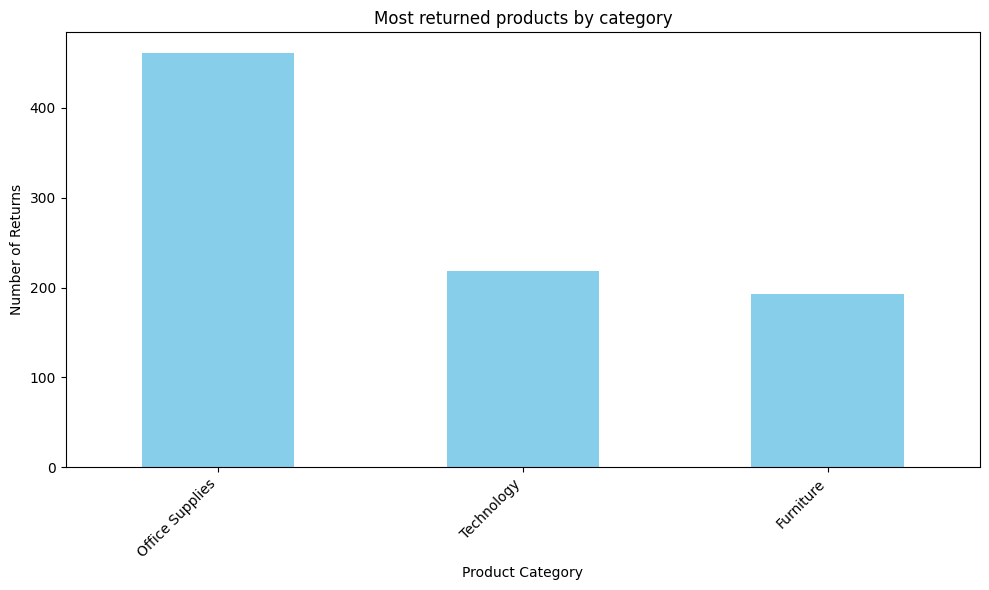

<Figure size 1000x600 with 0 Axes>

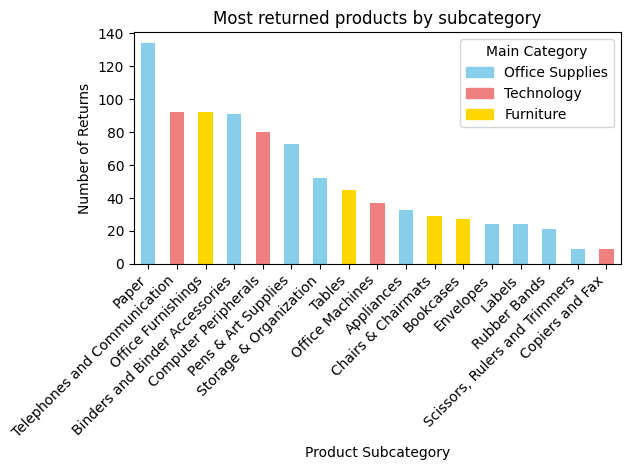

In [162]:
# Get numbers for questions
print('Unique Orders: '+str(sales['orderId'].nunique()))
print('Unique returned Orders:'+str(returnstatus['Order ID'].nunique()))

# Connection params
driver='postgresql'
username='dab_ds23241a_237'
dbname=username # 
password='yaiy2gzjumSdTfVA'
server='bronto.ewi.utwente.nl'
port='5432'

# Creating the connetcion pool for SQL and sending dataframes over to the server.
engine = create_engine(f'{driver}://{username}:{password}@{server}:{port}/{dbname}')
product.to_sql('Product', engine,schema='ass3', index=False, if_exists='replace')
sales.drop(columns=['orderId'], errors='ignore').to_sql('Sales', engine,schema='ass3',index=False, if_exists='replace')
customer.to_sql('Customer', engine,schema='ass3',index=False, if_exists='replace')
returnStatus.to_sql('ReturnStatus', engine,schema='ass3',index=False, if_exists='replace')

# .execute() on engine is legacy and not supported in SQLAlchmy 2.0, thus connection.execute() is used
with engine.connect() as conn:
    result = conn.execute(text("""SELECT table_name FROM information_schema.tables
where table_schema='ass3'"""))

# Retrieving data from server
product_data = pd.read_sql_table('Product', engine, schema='ass3')
customer_data = pd.read_sql_table('Customer', engine, schema='ass3')
sales_data = pd.read_sql_table('Sales', engine, schema='ass3')
return_status_data = pd.read_sql_table('ReturnStatus', engine, schema='ass3')

# Merging sales/products and filtering on the count of returned items
merged_data = pd.merge(sales_data, product_data, on='productid')
returned_products = merged_data[merged_data['returnstatusid'] == 1]

returns_count_category = returned_products['category'].value_counts()
returns_count_sub_category = returned_products['subcategory'].value_counts()

# Add categories to subcategories with colors
subcategory_to_category = product_data.set_index('subcategory')['category'].to_dict()
returns_count_sub_category_df = pd.DataFrame({'subcategory': returns_count_sub_category.index, 'count': returns_count_sub_category})
returns_count_sub_category_df['main_category'] = returns_count_sub_category_df['subcategory'].map(subcategory_to_category)
colors = returns_count_sub_category_df['main_category'].map({'Office Supplies': 'skyblue', 'Technology': 'lightcoral', 'Furniture': 'gold'})

plt.figure(figsize=(10, 6))
returns_count_category.plot(kind='bar', color='skyblue')
plt.title('Most returned products by category')
plt.xlabel('Product Category')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
ax = returns_count_sub_category_df.plot(kind='bar', x='subcategory', y='count', color=colors, legend=False)
plt.title('Most returned products by subcategory')
plt.xlabel('Product Subcategory')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45, ha='right')
legend_labels = {'Office Supplies': 'skyblue', 'Technology': 'lightcoral', 'Furniture': 'gold'}
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_labels.values()]
ax.legend(handles, legend_labels.keys(), title='Main Category')
plt.tight_layout()
plt.show()

In [163]:
product_data.info()
customer_data.info()
sales_data.info()
return_status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productid    1263 non-null   int64 
 1   name         1263 non-null   object
 2   category     1263 non-null   object
 3   subcategory  1263 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     1832 non-null   int64 
 1   customer_name  1832 non-null   object
 2   province       1832 non-null   object
 3   region         1832 non-null   object
 4   segment        1832 non-null   object
dtypes: int64(1), object(4)
memory usage: 71.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 10 columns):
 #   Column          Non-Null Co